# Programming Language

We present and implement the symbolic execution techniques presented in this book for a statically typed, imperative,
proper subset of the Python language which we call *minipy*. The language supports Booleans, Integers, and (possibly
nested) tuples of Integers, first-order function definitions, assignments, and the statement types `pass`, `if`,
`while`, `try`-`except`, and `break` and `continue`. Examples of unsupported Python features are classes and objects,
strings, floats, nested function definitions and lambdas, comprehensions and generators, `for` loops, and the `raise`
statement. minipy comes with some standard builtin functions like `len`.

For example, the following is a valid minipy program:[^while_else]

In [1]:
def find(needle: int, haystack: tuple) -> int:
    i = 0
    while i < len(haystack):
        if haystack[i] == needle:
            break
        else:
            i = i + 1
            continue
    else:
        return -1
    return i
t = (1, 2, 3, 4, )
x = find(3, t)
y = find(5, t)

Let us inspect the results of this computation:[^print_strings]

In [2]:
print(f"x = {x}")
print(f"y = {y}")

x = 2
y = -1


The type annotations like `: int` for function arguments and `-> int` for return types of functions, which are optional
in Python (and not checked by the standard interpreter) are required in minipy. Since furthermore, it is not possible
to declare variables without assignments, minipy is statically typed. We also forbid assignments of non-matching types
to previously assigned variables, which is entirely possible in Python. This is to simplify the presentation of our
symbolic analyses.

Since minipy does not support classes and objects, `except` clauses are restricted to `except ExceptionType` without an `as` clause:

In [3]:
def div(x: int, y: int) -> int:
    try:
        return x // y
    except ArithmeticError:
        return -1

In the following, we define a parser and interpreter for minipy. While we could also use the Python interpreter, since minipy is a subset of Python, we define our own one to be able to easily extend it later with additional features. Furthermore, we will define symbolic and concolic interpreters based on the basic interpreter defined in this section.

## Parser

Our parser is a Packrat parser {cite}`ford-02` for a [Parsing Expression Grammar (PEG)](https://en.wikipedia.org/wiki/Parsing_expression_grammar) of minipy. For both the parser and interpreter, we use definitions from the [Fuzzing Book](https://www.fuzzingbook.org/). The grammar itself is inspired by the [official Python 3 reference grammar](https://docs.python.org/3/reference/grammar.html).

In [4]:
import string
from fuzzingbook.Grammars import srange

In [5]:
MINIPY_GRAMMAR = {
    "<start>": ["<stmts>"],
    "<stmts>": ["<stmt><NEWLINE><stmts>", "<stmt>"],
    "<stmt>": ["<compound_stmt>", "<simple_stmt>"],
    "<simple_stmt>": [
        "pass",
        "break",
        "continue",
        "<return_stmt>",
        "<assignment>",
        "<expression>",
    ],
    "<compound_stmt>": [
        "<function_def>",
        "<try_stmt>",
        "<if_stmt>",
        "<while_stmt>"
    ],
    "<assignment>": ["<NAME> = <expression>"],
    "<return_stmt>": ["return <expression>"],
    "<if_stmt>": ["if <expression>:<block><maybe_else_block>"],
    "<maybe_else_block>": ["<NEWLINE>else:<block>", ""],
    "<while_stmt>": ["while <expression>:<block><maybe_else_block>"],
    "<try_stmt>": ["try:<block><except_block>"],

    "<function_def>": ["def <NAME>(<params>) -> <type>:<block>"],

    "<except_block>": [
        "<NEWLINE>except <NAME>:<block>",
        "<NEWLINE>except:<block>"],
    "<block>": ["<NEWLINE><INDENT><stmts><DEDENT>", "<simple_stmt>"],

    "<params>": ["<param>, <params>", "<param>", ""],
    "<param>": ["<NAME>: <type>"],

    "<type>": ["int", "bool", "tuple"],

    "<expression>": ["<conjunction><or_conjunctions>"],
    "<or_conjunctions>": ["<or_conjunction><or_conjunctions>", ""],
    "<or_conjunction>": [" or <conjunction>"],
    "<conjunction>": ["<inversion><and_inversions>"],
    "<and_inversions>": ["<and_inversion><and_inversions>", ""],
    "<and_inversion>": [" and <inversion>"],
    "<inversion>": ["not <inversion>", "<comparison>", "(<expression>)"],
    "<comparison>": ["<sum><maybe_compare>"],
    "<maybe_compare>": [" <compare_op> <sum>", ""],
    "<compare_op>": ["==", "!=", "<=", ">=", "<", ">"],
    "<sum>": ["<term> <ssym> <sum>", "<term>"],
    "<ssym>": ["+", "-"],
    "<term>": [
        "<factor> <tsym> <term>",
        "<factor> <tsym> (<sum>)",
        "(<sum>) <tsym> <factor>",
        "(<sum>) <tsym> (<sum>)",

        "<factor>",
    ],
    "<tsym>": ["*", "//", "%"],
    "<factor>": ["+<factor>", "-<factor>", "<primary>"],
    "<primary>": [
        "<atom>[<expression>]",
        "<NAME>(<args>)[<expression>]",
        "<NAME>(<args>)",
        "<atom>"
    ],
    "<args>": ["<expression>, <args>", "<expression>", ""],
    "<atom>": ["True", "False", "<tuple>", "<NAME>", "<NUMBER>"],
    "<tuple>": ["(<expression>, <expression_list>)"],
    "<expression_list>": ["<expression>, <expression_list>", ""],

    "<NEWLINE>": ["\n"],
    "<NUMBER>": ["<DIGIT><NUMBER>", "<DIGIT>"],
    "<DIGIT>": srange(string.digits),
    "<NAME>": ["<INIT_CHAR><IDCHARS>"],
    "<INIT_CHAR>": srange(string.ascii_letters + "_"),
    "<IDCHARS>": ["<IDCHAR><IDCHARS>", "<IDCHAR>", ""],
    "<IDCHAR>": srange(string.ascii_letters + string.digits + "_"),
}

To keep the grammar simple, it is quite restrictive with respect to whitespace. For example, no empty lines between statements are allowed, and tuple definitions must adhere to the form `(1, 2, 3, )` (including the final `,` and space).

The interpretation of the `<INDENT>` and `<DEDENT>` nonterminals is such that they increase / decrease the indentation level; `<INDENT>` matches for additional spaces, `<DEDENT>` matches the empty string. To account for these special nonterminals, we slightly extended the PEG parser from the Fuzzing Book.

In [6]:
from functools import lru_cache
from fuzzingbook.Parser import PEGParser

In [7]:
class PythonPEGParser(PEGParser):
    INDENT_SIZE = 4

    def __init__(self, grammar, **kwargs):
        super().__init__(grammar, **kwargs)
        self.indent = 0

    def unify_rule(self, rule, text, at):
        if self.log:
            print('unify_rule: %s with %s' % (repr(rule), repr(text[at:])))
        results = []
        for token in rule:
            at, res = self.unify_key(token, text, self.indent, at)
            if res is None:
                return at, None
            results.append(res)
        return at, results

    @lru_cache(maxsize=None)
    def unify_key(self, key, text, indent, at=0):
        # NOTE: Passing indent as a parameter is necessary for sound caching.
        if key == "<INDENT>":
            new_indent = (indent + 1) * PythonPEGParser.INDENT_SIZE
            if text[at:].startswith("".ljust(new_indent)):
                self.indent += 1
                if self.log:
                    print(f"Increasing indent to {new_indent} spaces.")
                return at + new_indent, ("".ljust(new_indent), [])
            else:
                return at, None

        if key == "<DEDENT>":
            new_indent = (indent - 1) * PythonPEGParser.INDENT_SIZE
            self.indent -= 1
            if self.log:
                print(f"Decreasing indent to {new_indent} spaces.")
            return at, ("", [])

        if self.indent > 0 and len(text) > at - 1 and text[at - 1] == "\n":
            if text[at:].startswith("".ljust(self.indent * PythonPEGParser.INDENT_SIZE)):
                at += self.indent * PythonPEGParser.INDENT_SIZE
            else:
                return at, None

        if key not in self.cgrammar:
            if text[at:].startswith(key):
                return at + len(key), (key, [])
            else:
                return at, None
        for rule in self.cgrammar[key]:
            to, res = self.unify_rule(rule, text, at)
            if res is not None:
                return to, (key, res)

        return 0, None

Running the parser produces a parse tree:

In [12]:
from fuzzingbook.GrammarFuzzer import display_tree
import graphviz

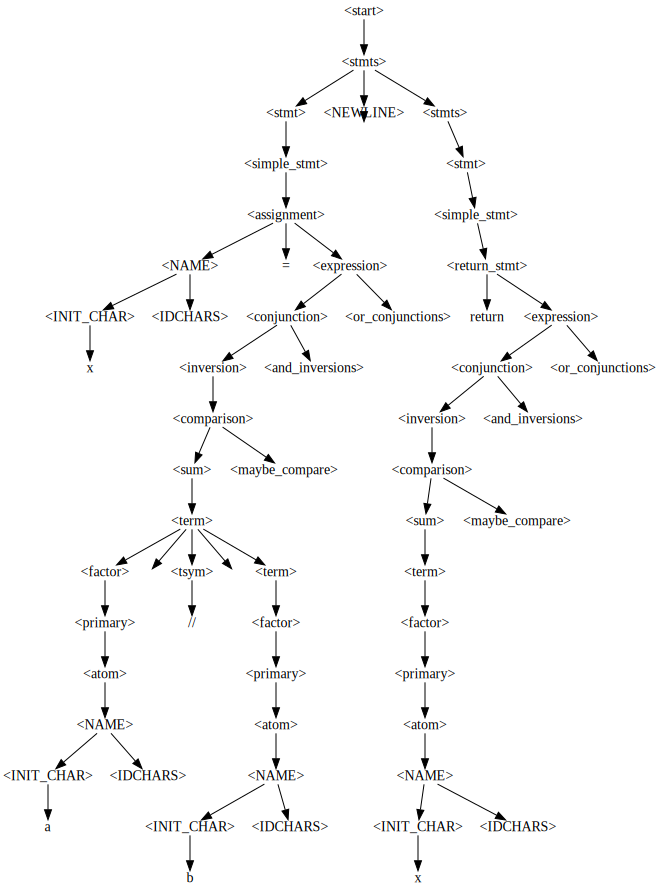

In [13]:
example_program = """x = a // b
return x"""
parser = PythonPEGParser(MINIPY_GRAMMAR)
tree = parser.parse(example_program)[0]
display_tree(tree)

Subsequently, we define an interpreter for processing minipy parse trees.

## Interpreter

The Python type `ValueType` is the union type of all types to which minipy expressions can evaluate.

In [14]:
from typing import Tuple, Union

In [15]:
NestedIntTuple = Tuple[Union[int, 'NestedIntTuple'], ...]
ValueType = Union[int, bool, NestedIntTuple]

We also need syntactical types for minipy.

In [17]:
class Type:
    def __init__(self, name: str):
        self.name = name

    def __repr__(self):
        return f"Type({self.name})"

    def __str__(self):
        return self.name

In [18]:
INT_TYPE = Type("int")
BOOL_TYPE = Type("bool")
TUPLE_TYPE = Type("tuple")

The function `get_type` returns a syntactical type either for the type name or a value of the type.

In [19]:
def get_type(expr: Union[str, ValueType]) -> Type:
    if type(expr) is str:
        return INT_TYPE if expr == "int" else (TUPLE_TYPE if expr == "tuple" else "bool")
    elif type(expr) is int:
        return INT_TYPE
    elif type(expr) is bool:
        return BOOL_TYPE
    elif type(expr) is tuple:
        return TUPLE_TYPE

    assert False

Next, we define the classes for variables and *environments*. A variable has a name and a type. An environment is a mapping from variables to values. Environments are used to evaluating expressions, and are updated by executing statements (note that minipy expressions are side-effect free, apart from the fact that their evaluation may raise exceptions).

In [20]:
class Variable:
    def __init__(self, name: str, type: Type):
        self.name = name
        self.type = type

    def __repr__(self):
        return f"Variable({self.name}, {self.type})"

    def __str__(self):
        return self.name

In [78]:
from typing import Optional, Dict, Callable
import copy

In [32]:
class Environment:
    def __init__(self,
                 declared_variables: Optional[Dict[str, Variable]] = None,
                 env: Optional[Dict[str, ValueType]] = None):
        self.declared_variables: Dict[str, Variable] = \
            {} if declared_variables is None else copy.deepcopy(declared_variables)
        self.env: Dict[str, ValueType] = {} if env is None else copy.deepcopy(env)

    def copy(self):
        return Environment(self.declared_variables, self.env, self.functions)

    def __getitem__(self, item):
        if item in self.declared_variables:
            return self.env[item]
        else:
            raise AttributeError(f"Attempt to read uninitialized variable {item}")

    def get_variable_type(self, var_name: str) -> Type:
        if var_name in self.declared_variables:
            return self.declared_variables[var_name].type
        else:
            raise AttributeError(f"Attempt to read uninitialized variable {var_name}")

    def __setitem__(self, key, value):
        assert type(key) is Variable
        existing_type = self.declared_variables.get(key.name, key).type
        if existing_type != key.type:
            raise RuntimeError(f"Incompatible assignment types for variable {key.name}: "
                               f"{key.type}, previously: {existing_type}")

        self.declared_variables[key.name] = key
        self.env[key.name] = value

    def __repr__(self):
        return f"Environment({repr(self.env)}, {repr(self.functions)})"

In [33]:
environment = Environment()
environment[Variable("x", INT_TYPE)] = 42
environment["x"]

42

In [34]:
from fuzzingbook.ExpectError import ExpectError

In [36]:
with ExpectError():
    environment["a"]

Traceback (most recent call last):
  File "<ipython-input-36-0e2baa89cd3a>", line 2, in <module>
    environment["a"]
  File "<ipython-input-32-7ea278669ff8>", line 16, in __getitem__
    raise AttributeError(f"Attempt to read uninitialized variable {item}")
AttributeError: Attempt to read uninitialized variable a (expected)


In [37]:
environment[Variable("x", INT_TYPE)] = 17
environment["x"]

17

In [39]:
with ExpectError():
    environment[Variable("x", BOOL_TYPE)] = False

Traceback (most recent call last):
  File "<ipython-input-39-4e516df8f596>", line 2, in <module>
    environment[Variable("x", BOOL_TYPE)] = False
  File "<ipython-input-32-7ea278669ff8>", line 28, in __setitem__
    raise RuntimeError(f"Incompatible assignment types for variable {key.name}: "
RuntimeError: Incompatible assignment types for variable x: bool, previously: int (expected)


For conveniently defining the parser, we define a function `match` for matching parse tree elements to a tuple of expected nonterminals. `match` will return `None` if the tree does not match the expected structure; otherwise, it returns a tuple of the same length as the input nonterminal tuple containing the instantiations of these nonterminals. Once a searched-for nonterminal has been found, `match` continues with the next path in the tree, using the `next_path` function also shown below.

In [42]:
from typing import List

In [43]:
ParseTree = Tuple[str, List['ParseTree']]
Path = Tuple[int, ...]

In [44]:
def match(symbols: Tuple[str, ...],
          tree: ParseTree,
          path: Path = (),
          result: Tuple[ParseTree, ...] = ()) -> Optional[Tuple[ParseTree, ...]]:
    if not symbols:
        return result if next_path(path, tree) is None else None

    node, children = get_subtree(path, tree)

    if node == symbols[0] or symbols[0] == "<INDENT>" and node.isspace() and len(node) % 4 == 0:
        result += ((node, children),)

        if len(symbols) == 1:
            return result if next_path(path, tree) is None else None

        next_p = next_path(path, tree)
        if next_p is None:
            return None

        return match(symbols[1:], tree, next_p, result)
    else:
        if not children:
            next_p = next_path(path, tree)
            if next_p is None:
                return None
            return match(symbols, tree, next_p, result)
        else:
            return match(symbols, tree, path + (0,), result)

In [45]:
def next_path(path: Path, tree: ParseTree) -> Optional[Path]:
    """Returns the next path in the tree; does not proceed towards leaves!"""
    if not path:
        return None

    node, children = get_subtree(path[:-1], tree)
    if len(children) > path[-1] + 1:
        return path[:-1] + (path[-1] + 1,)
    else:
        return next_path(path[:-1], tree)

A *path* is a tuple of integers pointing to a particular subtree. Consider the following tree:

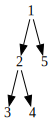

In [47]:
tree = ("1", [("2", [("3", []), ("4", [])]), ("5", [])])
display_tree(tree)

Then the path `(0, 1)` points to the subtree `("4", [])`:

In [48]:
def get_subtree(path: Path, tree: ParseTree) -> ParseTree:
    node, children = tree

    if not path:
        return tree

    return get_subtree(path[1:], children[path[0]])

In [58]:
display_tree(get_subtree((0, 1), tree))

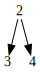

In [59]:
display_tree(get_subtree((0,), tree))

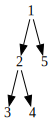

In [60]:
display_tree(get_subtree((), tree))

Let's try out the `match` function.

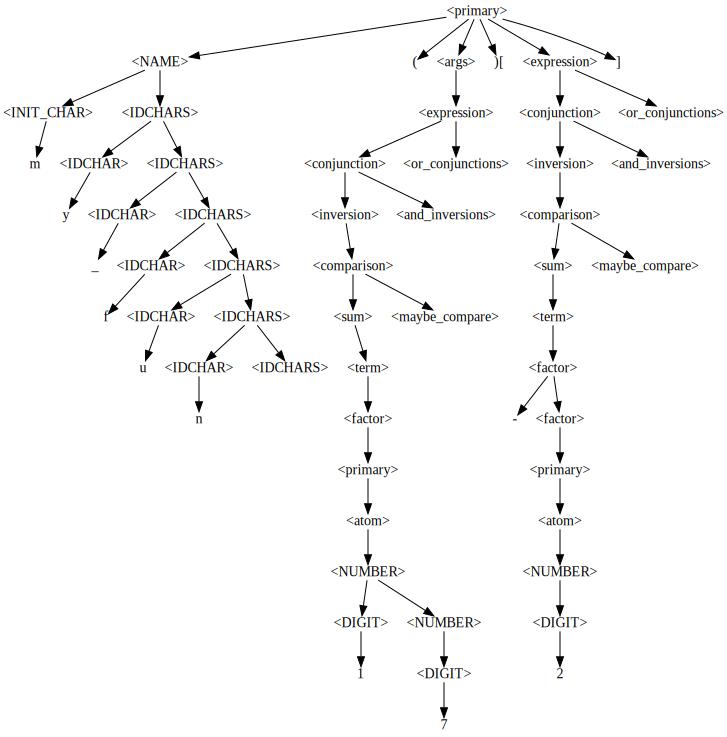

In [62]:
inp = "my_fun(17)[-2]"
parser = PythonPEGParser(MINIPY_GRAMMAR)
tree = next(parser.parse_on(inp, "<primary>"))
display_tree(tree)

In [71]:
m_res = match(("<atom>",), tree)
m_res is None

True

In [66]:
from fuzzingbook.GrammarFuzzer import tree_to_string

In [67]:
m_res = match(("<NAME>", "(", "<args>", ")[", "<expression>", "]"), tree)
list(map(tree_to_string, m_res))

['my_fun', '(', '17', ')[', '-2', ']']

In [70]:
dict(zip(("<NAME>", "(", "<args>", ")[", "<expression>", "]"), list(map(tree_to_string, m_res))))

{'<NAME>': 'my_fun',
 '(': '(',
 '<args>': '17',
 ')[': ')[',
 '<expression>': '-2',
 ']': ']'}

We are now ready to define the minipy interpreter. Its top-level functions are `execute(self, stmt: ParseTree, environment: Environment) -> None` for the execution of statements, and `evaluate(self, expr: ParseTree, environment: Environment) -> ValueType` for the evaluation of expressions. Both functions simply delegate to appropriate interpretation functions based on a dictionary from nonterminals to interpretations.

In [72]:
class Interpreter:
    def __init__(self):
        self.stmt_interpretations: Dict[str, Callable[[ParseTree, Environment], None]] = {}
        self.expr_interpretations: Dict[str, Callable[[ParseTree, Environment], ValueType]] = {}
            
    def execute(self, stmt: ParseTree, environment: Environment) -> None:
        node, _ = stmt
        if node in self.stmt_interpretations:
            self.stmt_interpretations[node](stmt, environment)
            return

        assert False
            
    def evaluate(self, expr: ParseTree, environment: Environment) -> ValueType:
        node, _ = expr
        if node in self.expr_interpretations:
            return self.expr_interpretations[node](expr, environment)

        assert False

The evaluation function for the `<sum>` nonterminal, for example, looks like follows:

```python
def evaluate_sum(self, expr: ParseTree, environment: Environment) -> ValueType:
    if m_res := match(("<term>", " ", "<ssym>", " ", "<sum>"), expr):
        eval_res_1 = self.evaluate_term(m_res[0], environment)
        eval_res_2 = self.evaluate_sum(m_res[4], environment)

        operator_map: Dict[str, Callable] = {"+": operator.add, "-": operator.sub}
        return operator_map[tree_to_string(m_res[2])](eval_res_1, eval_res_2)
    elif m_res := match(("<term>",), expr):
        return self.evaluate_term(m_res[0], environment)

    assert False
```

To inspect the code of the interpreter with a complete implementation for the evaluation of expressions, press the toggle on the right.

In [76]:
import operator


class Interpreter(Interpreter):
    def __init__(self):
        self.stmt_interpretations: Dict[str, Callable[[ParseTree, Environment], None]] = {}
        self.expr_interpretations: Dict[str, Callable[[ParseTree, Environment], ValueType]] = {
            "<expression>": self.evaluate_expression,
            "<conjunction>": self.evaluate_conjunction,
            "<inversion>": self.evaluate_inversion,
            "<comparison>": self.evaluate_comparison,
            "<sum>": self.evaluate_sum,
            "<term>": self.evaluate_term,
            "<factor>": self.evaluate_factor,
            "<primary>": self.evaluate_primary,
            "<atom>": self.evaluate_atom,
            "<tuple>": self.evaluate_tuple,
        }

    def evaluate_expression(self, expr: ParseTree, environment: Environment) -> ValueType:
        m_res = match(("<conjunction>", "<or_conjunctions>"), expr)
        assert m_res is not None

        conj_eval = self.evaluate_conjunction(m_res[0], environment)

        if tree_to_string(m_res[1]) == "":
            return conj_eval

        assert type(conj_eval) is bool

        result = conj_eval
        remaining_tree = m_res[1]

        while not result:
            m_res = match((" or ", "<conjunction>", "<or_conjunctions>"), remaining_tree)
            if m_res is None:
                assert tree_to_string(remaining_tree) == ""
                break

            result = result or self.evaluate_conjunction(m_res[1], environment)
            remaining_tree = m_res[2]

        return result

    def evaluate_conjunction(self, expr: ParseTree, environment: Environment) -> ValueType:
        m_res = match(("<inversion>", "<and_inversions>"), expr)
        assert m_res is not None

        inv_eval = self.evaluate_inversion(m_res[0], environment)

        if tree_to_string(m_res[1]) == "":
            return inv_eval

        assert type(inv_eval) is bool

        result = inv_eval
        remaining_tree = m_res[1]

        while not result:
            m_res = match((" and ", "<inversion>", "<and_inversions>"), remaining_tree)
            if m_res is None:
                assert tree_to_string(remaining_tree) == ""
                break

            result = result and self.evaluate_inversion(m_res[1], environment)
            remaining_tree = m_res[2]

        return result

    def evaluate_inversion(self, expr: ParseTree, environment: Environment) -> ValueType:
        if m_res := match(("not ", "<inversion>"), expr):
            return not self.evaluate_inversion(m_res[1], environment)
        elif m_res := match(("<comparison>",), expr):
            return self.evaluate_comparison(m_res[0], environment)
        elif m_res := match(("(", "<expression>", ")"), expr):
            return self.evaluate_expression(m_res[1], environment)

        assert False

    def evaluate_comparison(self, expr: ParseTree, environment: Environment) -> ValueType:
        m_res = match(("<sum>", "<maybe_compare>"), expr)
        assert m_res is not None

        eval_sum_result = self.evaluate_sum(m_res[0], environment)
        sub_m_res = match((" ", "<compare_op>", " ", "<sum>"), m_res[1])
        if sub_m_res is None:
            assert tree_to_string(m_res[1]) == ""
            return eval_sum_result

        eval_sum_2_result = self.evaluate_sum(sub_m_res[3], environment)

        operator_map: Dict[str, Callable] = {
            "==": operator.eq,
            "!=": operator.ne,
            "<=": operator.le,
            ">=": operator.ge,
            "<": operator.lt,
            ">": operator.gt
        }

        return operator_map[tree_to_string(sub_m_res[1])](eval_sum_result, eval_sum_2_result)

    def evaluate_sum(self, expr: ParseTree, environment: Environment) -> ValueType:
        if m_res := match(("<term>", " ", "<ssym>", " ", "<sum>"), expr):
            eval_res_1 = self.evaluate_term(m_res[0], environment)
            eval_res_2 = self.evaluate_sum(m_res[4], environment)

            operator_map: Dict[str, Callable] = {"+": operator.add, "-": operator.sub}
            return operator_map[tree_to_string(m_res[2])](eval_res_1, eval_res_2)
        elif m_res := match(("<term>",), expr):
            return self.evaluate_term(m_res[0], environment)

        assert False

    def evaluate_term(self, expr: ParseTree, environment: Environment) -> ValueType:
        operator_map: Dict[str, Callable] = {
            "*": operator.mul,
            "//": lambda a, b: a // b,
            "%": operator.mod
        }

        if m_res := match(("<factor>", " ", "<tsym>", " ", "<term>"), expr):
            eval_res_1 = self.evaluate_factor(m_res[0], environment)
            eval_res_2 = self.evaluate_term(m_res[-1], environment)
            return operator_map[tree_to_string(m_res[2])](eval_res_1, eval_res_2)
        elif m_res := match(("<factor>", " ", "<tsym>", " (", "<sum>", ")"), expr):
            eval_res_1 = self.evaluate_factor(m_res[0], environment)
            eval_res_2 = self.evaluate_sum(m_res[-2], environment)
            return operator_map[tree_to_string(m_res[2])](eval_res_1, eval_res_2)
        elif m_res := match(("(", "<sum>", ") ", "<tsym>", " ", "<factor>"), expr):
            eval_res_1 = self.evaluate_sum(m_res[1], environment)
            eval_res_2 = self.evaluate_factor(m_res[-1], environment)
            return operator_map[tree_to_string(m_res[3])](eval_res_1, eval_res_2)
        elif m_res := match(("(", "<sum>", ") ", "<tsym>", " (", "<sum>", ")"), expr):
            eval_res_1 = self.evaluate_sum(m_res[1], environment)
            eval_res_2 = self.evaluate_sum(m_res[-2], environment)
            return operator_map[tree_to_string(m_res[3])](eval_res_1, eval_res_2)
        elif m_res := match(("<factor>",), expr):
            return self.evaluate_factor(m_res[0], environment)

        assert False

    def evaluate_factor(self, expr: ParseTree, environment: Environment) -> ValueType:
        if m_res := match(("+", "<factor>"), expr):
            eval_res = self.evaluate_factor(m_res[1], environment)
            assert type(eval_res) is int
            return eval_res
        elif m_res := match(("-", "<factor>"), expr):
            eval_res = self.evaluate_factor(m_res[1], environment)
            assert type(eval_res) is int
            return -eval_res
        elif m_res := match(("<primary>",), expr):
            return self.evaluate_primary(m_res[0], environment)

        assert False

    def evaluate_primary(self, expr: ParseTree, environment: Environment) -> ValueType:
        def eval_fun_call(m_res: Tuple[ParseTree]) -> ValueType:
            f_name = tree_to_string(m_res[0])
            if f_name not in environment.functions:
                raise NameError(f"name '{f_name}' is not defined")
            args = self.evaluate_args(m_res[2], environment)
            params, ret_type, fun = environment.functions[f_name]
            if len(args) != len(params):
                raise TypeError(f"{f_name}({', '.join(map(str, params))}) takes {len(params)} "
                                f"argument(s) but {len(args)} were given")
            fun_result = fun(*args)
            if type(fun_result).__name__ != str(ret_type):
                raise TypeError(f"Unexpected return type {type(fun_result)} for function "
                                f"'{f_name}', expected {ret_type}")
            return fun_result

        if m_res := match(("<atom>", "[", "<expression>", "]"), expr):
            eval_atom_res = self.evaluate_atom(m_res[0], environment)
            if type(eval_atom_res) is not tuple:
                raise TypeError(f"'{type(eval_atom_res)} is not subscriptable")
            eval_expr_res = self.evaluate_expression(m_res[2], environment)
            if type(eval_expr_res) is not int:
                raise TypeError(f"list indices must be integers, not {type(eval_expr_res)}")

            return eval_atom_res[eval_expr_res]
        elif m_res := match(("<NAME>", "(", "<args>", ")[", "<expression>", "]"), expr):
            fun_call_result = eval_fun_call(m_res)
            if type(fun_call_result) is not tuple:
                raise TypeError(f"'{type(fun_call_result)} is not subscriptable")
            eval_expr_res = self.evaluate_expression(m_res[-2], environment)
            if type(eval_expr_res) is not int:
                raise TypeError(f"list indices must be integers, not {type(eval_expr_res)}")

            return fun_call_result[eval_expr_res]
        elif m_res := match(("<NAME>", "(", "<args>", ")"), expr):
            return eval_fun_call(m_res)
        elif m_res := match(("<atom>",), expr):
            return self.evaluate_atom(m_res[0], environment)

        assert False

    def evaluate_args(self, expr: ParseTree, environment: Environment) -> List[ValueType]:
        result: List[ValueType] = []

        if m_res := match(("<expression>", ", ", "<args>"), expr):
            result.append(self.evaluate_expression(m_res[0], environment))
            result.extend(self.evaluate_args(m_res[-1], environment))
        elif m_res := match(("<expression>",), expr):
            result.append(self.evaluate_expression(m_res[0], environment))
        elif tree_to_string(expr) == "":
            pass

        return result

    def evaluate_atom(self, expr: ParseTree, environment: Environment) -> ValueType:
        atom_str = tree_to_string(expr)

        if m_res := match(("<tuple>",), expr):
            return self.evaluate_tuple(m_res[0], environment)
        elif match(("True",), expr):
            return True
        elif match(("False",), expr):
            return False
        elif match(("<NUMBER>",), expr):
            return int(atom_str)
        elif match(("<NAME>",), expr):
            return environment[atom_str]

        assert False

    def evaluate_tuple(self, expr: ParseTree, environment: Environment) -> ValueType:
        m_res = match(("(", "<expression>", ", ", "<expression_list>", ")"), expr)
        assert m_res is not None
        expr_eval = self.evaluate_expression(m_res[1], environment)

        if tree_to_string(m_res[-2]) == "":
            return expr_eval,

        result = [expr_eval]
        remaining_tree = m_res[-2]

        while True:
            m_res = match(("<expression>", ", ", "<expression_list>"), remaining_tree)
            if m_res is None:
                assert tree_to_string(remaining_tree) == ""
                break

            result.append(self.evaluate_expression(m_res[0], environment))
            remaining_tree = m_res[2]

        return tuple(result)

In [77]:
interpreter = Interpreter()
environment = Environment()
interpreter.evaluate(next(parser.parse_on("3 + 4 * 2", "<expression>")), environment)

11

In [79]:
interpreter.evaluate(next(parser.parse_on("(3 + 4) * 2", "<expression>")), environment)

14

In [80]:
with ExpectError():
    interpreter.evaluate(next(parser.parse_on("1 // 0", "<expression>")), environment)

Traceback (most recent call last):
  File "<ipython-input-80-b390a096e217>", line 2, in <module>
    interpreter.evaluate(next(parser.parse_on("1 // 0", "<expression>")), environment)
  File "<ipython-input-72-01c2434748ef>", line 17, in evaluate
    return self.expr_interpretations[node](expr, environment)
  File "<ipython-input-76-b3bf4d790f1a>", line 21, in evaluate_expression
    conj_eval = self.evaluate_conjunction(m_res[0], environment)
  File "<ipython-input-76-b3bf4d790f1a>", line 46, in evaluate_conjunction
    inv_eval = self.evaluate_inversion(m_res[0], environment)
  File "<ipython-input-76-b3bf4d790f1a>", line 71, in evaluate_inversion
    return self.evaluate_comparison(m_res[0], environment)
  File "<ipython-input-76-b3bf4d790f1a>", line 81, in evaluate_comparison
    eval_sum_result = self.evaluate_sum(m_res[0], environment)
  File "<ipython-input-76-b3bf4d790f1a>", line 108, in evaluate_sum
    return self.evaluate_term(m_res[0], environment)
  File "<ipython-input-76

**TODO**: Execution of statements.

## References

```{bibliography}
```

[^while_else]: The code demonstrates that minipy does support Pythons `while`-`else` syntax: The `else` branch after a
`while` loop is entered whenever the loop completed normally (and the guard evaluated to `False`), that is, not because
of a `break`, `return`, or thrown exception.

[^print_strings]: The below code is not a minipy program, since minipy does not support strings or print statements. We clearly mark minipy code boxes throughout this book; Python boxes are not marked.